## imports

In [5]:
import architectures as ar
import torch
from torch import nn

## model architecture tests

In [6]:
args = []
dilations = [2,4,8,8,4]
strides=[5,4,3,2,2]
kernels=[10,8,4,4,4]
encode_dim=32


In [7]:
vicreg = ar.VicRegWaves(args,dilations,strides,kernels,encode_dim,[32,64,128,64,32])

In [8]:
bsz = 128
a1 = [torch.normal(torch.sin(torch.linspace(0,2*torch.pi,441)),torch.tensor([1])) for _ in range(bsz)]
a1 = torch.stack(a1,axis=0)[:,None,:]
print(a1.shape)

torch.Size([128, 1, 441])


In [9]:
def ProjectorTest(sizes):

    layers = []
    for ii in range(len(sizes) - 2):

        layers.append(nn.Linear(sizes[ii],sizes[ii+1]))
        layers.append(nn.BatchNorm1d(sizes[ii+1]))
        layers.append(nn.ReLU(True))
    layers.append(nn.Linear(sizes[-2],sizes[-1],bias=False))
    return nn.Sequential(*layers),layers

In [10]:
senc = vicreg.encoder.strided_encoder
denc = vicreg.encoder.dilated_encoder
proj = vicreg.projector
#sizes = vicreg.sizes
projTest,layers = ProjectorTest([32,64,128,64,32])

In [11]:
d1 = denc(a1)
s1 = senc(a1)
e1 = vicreg.encoder(a1)
ps = [e1]
for ii,layer in enumerate(layers):
    try:
        ps.append(layer(ps[ii]))
    except:
        print(f"failed on layer {ii+1}: input shape {ps[ii].shape}")
        layer(ps[ii])

loss = vicreg(a1[:64,:],a1[:64,:])

In [12]:
print(d1.shape,s1.shape,e1.shape,ps[-1].shape)

torch.Size([128, 16, 1]) torch.Size([128, 16, 1]) torch.Size([128, 32]) torch.Size([128, 32])


## dataset tests

In [13]:
import os
import glob 
import data as dt
import numpy as np

path = '/home/miles/mooney_server/Miles/fromComputer/birds_jq/CAGbirds/org545/data'
days = glob.glob(os.path.join(path,'[0-9]*'))
audio = [glob.glob(os.path.join(d,'denoised','*.wav')) for d in days]
rois = [glob.glob(os.path.join(d,'denoised_segments_syll','*.txt')) for d in days]
audio = sum(audio,[])
rois = sum(rois,[])

In [14]:
ds1 = dt.waveformSet(audio,rois,maxSegs=50,seed=100)


Pre-processing audio: 0it [00:00, ?it/s]
/home/miles/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/miles/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


max number of segments reached!
Getting positive pair indices
being efficient


Finding valid inds: 100%|██████████| 516/516 [00:00<00:00, 14125.28it/s]


In [15]:
x1,x2 = ds1[6]
x1n,x2n = x1.detach().cpu().numpy(), x2.detach().cpu().numpy()

In [16]:
from scipy.signal import stft

f1,t1,sxx1 = stft(x1n,fs=ds1.fs)
f2,t2,sxx2 = stft(x2n,fs=ds1.fs)
print(sxx1.shape)
print(sxx2.shape)

(129, 5)
(129, 5)


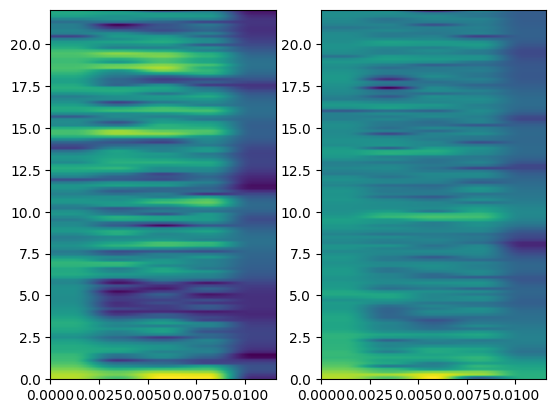

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
sxx1p = np.log(np.abs(sxx1))
sxx2p = np.log(np.abs(sxx2))
fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2)
#print(f1)
ax1.imshow(sxx1p,origin='lower',extent=[t1[0],t1[-1],f1[0]/1e3,f1[-1]/1e3],aspect='auto')
ax2.imshow(sxx2p,origin='lower',extent=[t2[0],t2[-1],f2[0]/1e3,f2[-1]/1e3],aspect='auto')

plt.show()
plt.close()

## testing model and loader

In [18]:
import os
import glob 
import data as dt
import numpy as np
from torch.utils.data import DataLoader

#### Load data #####
path = '/home/miles/mooney_server/Miles/fromComputer/birds_jq/CAGbirds/org545/data'
days = glob.glob(os.path.join(path,'[0-9]*'))
audio = [glob.glob(os.path.join(d,'denoised','*.wav')) for d in days]
rois = [glob.glob(os.path.join(d,'denoised_segments_syll','*.txt')) for d in days]
audio = sum(audio,[])
rois = sum(rois,[])

ds1 = dt.waveformSet(audio,rois,maxSegs=50,seed=100)
dl1 = DataLoader(ds1,batch_size=64,shuffle=True,num_workers = os.cpu_count()//3)


Pre-processing audio: 0it [00:00, ?it/s]
/home/miles/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/miles/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


max number of segments reached!
Getting positive pair indices
being efficient


Finding valid inds: 100%|██████████| 516/516 [00:00<00:00, 16572.31it/s]


In [19]:
import architectures as ar
#### Create model ####
args = []
dilations = [2,4,8,8,4]
strides=[5,4,3,2,2]
kernels=[10,8,4,4,4]
encode_dim=32

vicreg = ar.VicRegWaves(args,dilations,strides,kernels,encode_dim,[32,64,128,64,32])
senc = vicreg.encoder.strided_encoder
denc = vicreg.encoder.dilated_encoder
proj = vicreg.projector

In [20]:
for batch in dl1:

    x1,x2 = batch
    x1,x2 = x1[:,None,:],x2[:,None,:] # reshape to B x C x L
    print(x1.shape,x2.shape)
    d1,d2 = denc(x1),denc(x2)
    s1,s2 = senc(x1),senc(x2)
    e1,e2 = vicreg.encoder(x1),vicreg.encoder(x2)
    
    loss = vicreg(x1,x2)
    print(loss.shape)
    print(loss)
    assert False


torch.Size([64, 1, 441]) torch.Size([64, 1, 441])
torch.Size([])
tensor(1.2137, grad_fn=<AddBackward0>)


AssertionError: 

In [ ]:
print(denc)

Sequential(
  (0): Conv1d(1, 16, kernel_size=(10,), stride=(3,), padding=(2,), dilation=(2,), bias=False)
  (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Conv1d(16, 16, kernel_size=(8,), stride=(3,), padding=(4,), dilation=(4,), bias=False)
  (3): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): Conv1d(16, 16, kernel_size=(4,), stride=(2,), padding=(8,), dilation=(8,), bias=False)
  (5): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Conv1d(16, 16, kernel_size=(4,), stride=(2,), padding=(8,), dilation=(8,), bias=False)
  (7): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): Conv1d(16, 16, kernel_size=(4,), stride=(3,), padding=(4,), dilation=(4,), bias=False)
  (9): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


## testing model training

In [ ]:
import os
import glob 
import data as dt
import numpy as np
from torch.utils.data import DataLoader

#### Load data #####
path = '/home/miles/mooney_server/Miles/fromComputer/birds_jq/CAGbirds/org545/data'
days = glob.glob(os.path.join(path,'[0-9]*'))
audio = [glob.glob(os.path.join(d,'denoised','*.wav')) for d in days]
rois = [glob.glob(os.path.join(d,'denoised_segments_syll','*.txt')) for d in days]
audio = sum(audio,[])
rois = sum(rois,[])

split = int(round(0.8*len(audio)))
order = np.random.choice(len(audio),len(audio),replace=False)
trainAud,testAud = [audio[o] for o in order[:split]],[audio[o] for o in order[split:]]
trainRoi,testRoi = [rois[o] for o in order[:split]],[rois[o] for o in order[split:]]

dsTrain = dt.waveformSet(trainAud,trainRoi,maxSegs=1000,seed=100)
dsTest = dt.waveformSet(testAud,testRoi,maxSegs=300,seed=100)
dlTrain = DataLoader(dsTrain,batch_size=64,shuffle=True,num_workers = os.cpu_count()//3)
dlTest = DataLoader(dsTest,batch_size=64,shuffle=False,num_workers = os.cpu_count()//3)
loaders = {'train': dlTrain, 'test':dlTest}

Pre-processing audio: 8it [00:04,  1.75it/s]

max number of segments reached!
Getting positive pair indices
being efficient



/home/miles/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/miles/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
Finding valid inds: 100%|██████████| 9977/9977 [00:03<00:00, 2645.03it/s]
Pre-processing audio: 3it [00:00,  3.02it/s]


max number of segments reached!
Getting positive pair indices
being efficient


Finding valid inds: 100%|██████████| 2906/2906 [00:00<00:00, 9196.69it/s] 


In [ ]:
import architectures as ar
#### Create model ####
args = []
dilations = [2,4,8,8,4]
strides=[5,4,3,2,2]
kernels=[10,8,4,4,4]
encode_dim=32

vicreg = ar.VicRegWaves(args,dilations,strides,kernels,encode_dim,[32,64,128,64,32])
senc = vicreg.encoder.strided_encoder
denc = vicreg.encoder.dilated_encoder
proj = vicreg.projector

In [ ]:
from train import train
import os
#os.mkdir('/home/miles/vicreg_test')
train(vicreg,loaders,lr=0.001,nTrain=10000,saveFreq=1000,testFreq=100,id='test2',save_dir='/home/miles/vicreg_test')

training model:   0%|          | 0/10000 [00:00<?, ?it/s]/home/miles/.local/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
training model: 100%|██████████| 10000/10000 [4:57:33<00:00,  1.79s/it] 


## analysis, embedding, model loading

In [1]:
import os
import glob 
import data as dt
import numpy as np
from torch.utils.data import DataLoader

#### Load data #####
path = '/home/miles/mooney_server/Miles/fromComputer/birds_jq/CAGbirds/org545/data'
days = glob.glob(os.path.join(path,'[0-9]*'))
audio = [glob.glob(os.path.join(d,'denoised','*.wav')) for d in days]
rois = [glob.glob(os.path.join(d,'denoised_segments_syll','*.txt')) for d in days]
audio = sum(audio,[])
rois = sum(rois,[])

split = int(round(0.8*len(audio)))
order = np.random.choice(len(audio),len(audio),replace=False)
trainAud,testAud = [audio[o] for o in order[:split]],[audio[o] for o in order[split:]]
trainRoi,testRoi = [rois[o] for o in order[:split]],[rois[o] for o in order[split:]]

dsTrain = dt.waveformSet(trainAud,trainRoi,maxSegs=1000,seed=100)
dsTest = dt.waveformSet(testAud,testRoi,maxSegs=300,seed=100)
dlTrain = DataLoader(dsTrain,batch_size=64,shuffle=True,num_workers = os.cpu_count()//3)
dlTest = DataLoader(dsTest,batch_size=64,shuffle=False,num_workers = os.cpu_count()//3)
loaders = {'train': dlTrain, 'test':dlTest}

Pre-processing audio: 10it [00:01,  5.08it/s]


max number of segments reached!
Getting positive pair indices
being efficient


/home/miles/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/miles/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
Finding valid inds: 100%|██████████| 9812/9812 [00:03<00:00, 2568.87it/s]
Pre-processing audio: 2it [00:00,  3.22it/s]


max number of segments reached!
Getting positive pair indices
being efficient


Finding valid inds: 100%|██████████| 3066/3066 [00:00<00:00, 10775.03it/s]


In [2]:
import architectures as ar
#### Create model ####
args = []
dilations = [2,4,8,8,4]
strides=[5,4,3,2,2]
kernels=[10,8,4,4,4]
encode_dim=32

vicreg = ar.VicRegWaves(args,dilations,strides,kernels,encode_dim,[32,64,128,64,32])
senc = vicreg.encoder.strided_encoder
denc = vicreg.encoder.dilated_encoder
proj = vicreg.projector

In [3]:
from train import train
import os
#os.mkdir('/home/miles/vicreg_test')
model = train(vicreg,loaders,lr=0.001,nTrain=0,saveFreq=1000,testFreq=100,id='test3',save_dir='/home/miles/vicreg_test_scaled',chkpt=9000)


loading state from /home/miles/vicreg_test_scaled/checkpoint_9000.tar...
loading model params
loading optimizer state
Restoring epoch 9000


training model: 100%|██████████| 9000/9000 [00:00<?, ?it/s]


In [4]:
from analyze import embed_audio_file,plot_pc_embeddings,plot_umap_embeddings
import torch
gpu = torch.device('cuda')

/home/miles/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
Jax plugin configuration error: Exception when calling jax_plugins.xla_cuda12.initialize()
Traceback (most recent call last):
  File "/home/miles/.local/lib/python3.10/site-packages/jax/_src/xla_bridge.py", line 438, in discover_pjrt_plugins
    plugin_module.initialize()
  File "/home/miles/.local/lib/python3.10/site-packages/jax_plugins/xla_cuda12/__init__.py", line 78, in initialize
    options = xla_client.generate_pjrt_gpu_plugin_options()
AttributeError: module 'jaxlib.xla_client' has no attribute 'generate_pjrt_gpu_plugin_options'


In [5]:
from scipy.io import wavfile
fs,a = wavfile.read(audio[0])
print(np.amax(a))
print(np.amin(a))

audioLats = embed_audio_file(audio[0],model,gpu)


18849
-18913


In [6]:
audioLats,roiLats,chunks = embed_audio_file(audio[1],vicreg.cuda(gpu),gpu,rois[1])

/home/miles/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,


(6099,)
(6099, 32)


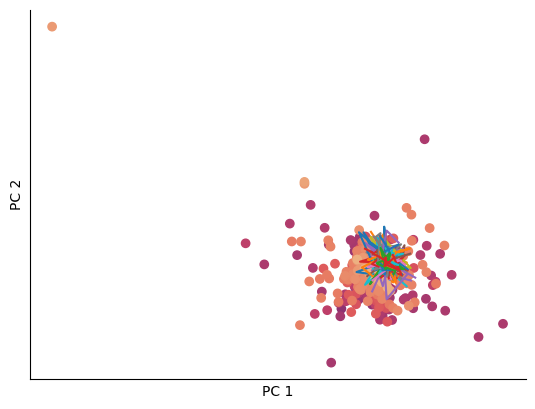

In [7]:
plot_pc_embeddings(audioLats,60,roiLatents=roiLats,roiAudio=chunks)

In [29]:
onoffs = np.loadtxt(rois[0]) 
fs,aud = wavfile.read(audio[0])
chunks,original = generate_overlapping_segs(aud,fs,onoffs[6])
lats = model.encoder(torch.from_numpy(chunks[:,None,:]).type(torch.FloatTensor).cuda(gpu)).detach().cpu().numpy()

In [24]:
print(len(chunks))
print(original.shape)
print(lats.shape)

19
(4096,)
(19, 32)


/home/miles/.local/lib/python3.10/site-packages/umap/spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


(6099,)
(6099, 32)


/home/miles/.local/lib/python3.10/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


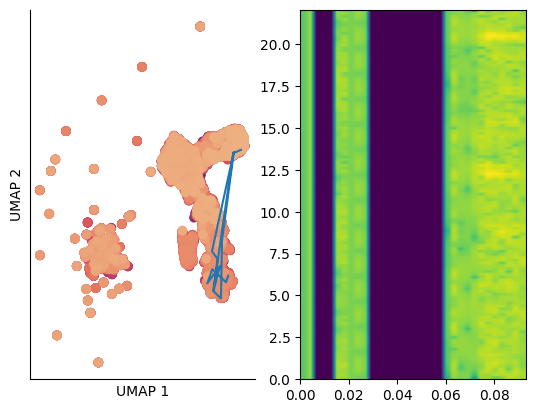

In [30]:
plot_umap_embeddings(audioLats,60,roiLatents=[lats],roiAudio=[original],fs=fs)

In [16]:
def generate_overlapping_segs(audio,fs,roi,overlap=0.5,seg_len = 0.01):

    audioTimes = np.linspace(0,len(audio)/fs,len(audio))

    on,off = roi
    #print(on,off)
    #sprint(seg_len* (1-overlap))
    roiTimes = np.arange(on,off,seg_len*(1-overlap))
    onInd,offInd = np.searchsorted(audioTimes,on),np.searchsorted(audioTimes,off)
    original = audio[onInd:offInd]
    outchunks = []
    
    seg_len_samples = int(round(fs * seg_len))
    for on in roiTimes:
        onInd,offInd = np.searchsorted(audioTimes,on), np.searchsorted(audioTimes,on+seg_len)
        outchunks.append(audio[onInd:offInd][:seg_len_samples])

    
    return np.vstack(outchunks),original




